## Tigray War Demand and Utility Analysis

##### *This notebook walks through the cleaning and analysis of Ehtiopia's food and expenditure data to understand the impacts of the Tigray War on demand and utility.*

In [1]:
!pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl (12 kB)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2.2.3


In [2]:
Ethiopia_Data = '1PVqM25qZyDz5K3jsLDu-JgPS5-vmro4wHk8k6OIB9Eo'

In [3]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

# Change 'Uganda_Data' to key of your own sheet in Sheets, above
x = read_sheets(Ethiopia_Data,sheet='Food Expenditures (2018-19)')
x = x.set_index(['i','t','m','j']).squeeze()


# Now prices
p = read_sheets(Ethiopia_Data,sheet='Food Prices (2018-19)').set_index(['t','m','j','u'])

p = p['Price']

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')

jidx = p.columns.intersection(x.index.levels[-1])
# Drop prices for goods we don't have expenditures for
p = p[jidx].T

# Household characteristics
d = read_sheets(Ethiopia_Data,sheet="Household Characteristics")
d.columns.name = 'k'

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)

d.set_index(['i','t','m'],inplace=True)

In [4]:
d.head()

k                             Females 00-03  Females 04-08  Females 09-13  \
i             t       m                                                     
1010101601002 2011-12 Tigray              0              0              1   
              2013-14 Tigray              1              1              1   
              2015-16 Tigray              0              0              0   
1010101601017 2011-12 Tigray              0              1              1   
              2013-14 Tigray              1              1              1   

k                             Females 14-18  Females 19-30  Females 31-50  \
i             t       m                                                     
1010101601002 2011-12 Tigray              0              0              1   
              2013-14 Tigray              0              0              1   
              2015-16 Tigray              0              0              0   
1010101601017 2011-12 Tigray              0              0              1   
              2013-14 Tigray              0              1              0   

k                             Females 51-99  Males 00-03  Males 04-08  \
i             t       m                                                 
1010101601002 2011-12 Tigray              1            0            1   
              2013-14 Tigray              1            0            1   
              2015-16 Tigray              1            0            0   
1010101601017 2011-12 Tigray              0            0            0   
              2013-14 Tigray              0            0            1   

k                             Males 09-13  Males 14-18  Males 19-30  \
i             t       m                                               
1010101601002 2011-12 Tigray            1            1            0   
              2013-14 Tigray            0            1            0   
              2015-16 Tigray            0            0            0   
1010101601017 2011-12 Tigray            2            0            0   
              2013-14 Tigray            1            1            0   

k                             Males 31-50  Males 51-99  log HSize  
i             t       m                                            
1010101601002 2011-12 Tigray            1            0   1.945910  
              2013-14 Tigray            1            0   2.079442  
              2015-16 Tigray            0            0   0.000000  
1010101601017 2011-12 Tigray            1            0   1.791759  
              2013-14 Tigray            1            0   2.079442

In [5]:
from cfe import Regression

result = Regression(y=y,d=d)

In [6]:
result.predicted_expenditures()

i                   t        m       j       
010101088800910017  2018-19  Tigray  Banana       13.616372
                                     Barley       29.423663
                                     Beef        152.220021
                                     Beetroot      9.713831
                                     Berbere      18.635439
                                                    ...    
7.10031E+16         2018-19  SNNP    Sugar         8.199711
                                     Tea           6.688172
                                     Teff         65.156824
                                     Tomato        7.975005
                                     Wheat        22.539978
Length: 191958, dtype: float64

<Axes: xlabel='yhat', ylabel='y'>

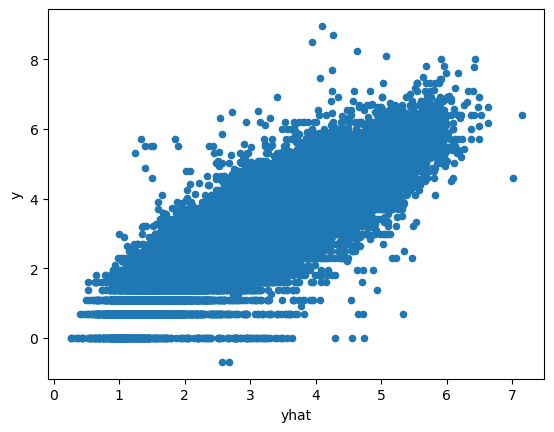

In [7]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

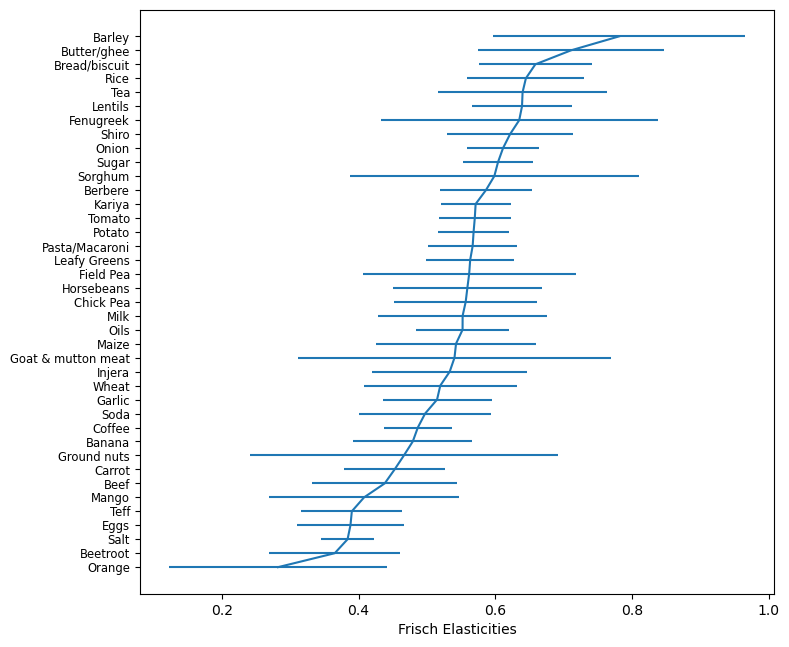

In [8]:
ax = result.graph_beta()

In [9]:
result.get_beta()

j
Banana                0.479178
Barley                0.780838
Beef                  0.438144
Beetroot              0.365002
Berbere               0.586266
Bread/biscuit         0.658454
Butter/ghee           0.710548
Carrot                0.452613
Chick Pea             0.556580
Coffee                0.486573
Eggs                  0.388004
Fenugreek             0.634856
Field Pea             0.561645
Garlic                0.514700
Goat & mutton meat    0.540216
Ground nuts           0.466189
Horsebeans            0.559037
Injera                0.533212
Kariya                0.571094
Leafy Greens          0.563143
Lentils               0.638976
Maize                 0.542419
Mango                 0.407950
Milk                  0.552095
Oils                  0.551995
Onion                 0.611191
Orange                0.281921
Pasta/Macaroni        0.566775
Potato                0.568128
Rice                  0.644632
Salt                  0.383775
Shiro                 0.621482
Soda  

In [10]:
result.get_gamma()

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize,Constant
j,,,,,,,,,,,,,,,,
Banana,0.011810,-0.064620,0.000871,0.013443,0.133738,0.141644,0.126503,0.032934,-0.077769,-0.049908,-0.024724,0.047068,0.238964,0.059762,0.166232,3.186060
Barley,0.129997,0.022144,0.173119,0.077375,-0.023983,0.051273,0.124006,-0.139137,0.056104,-0.066169,0.095584,0.093987,-0.005463,0.006414,0.308662,3.280411
Beef,-0.038712,-0.143079,-0.044804,0.106981,0.082911,0.092443,0.093977,-0.017334,-0.050165,-0.076351,0.018740,0.046138,0.188003,0.155703,0.228814,5.246494
Beetroot,0.001029,0.022451,0.057436,0.076431,0.059910,0.023900,-0.043512,0.070262,0.071069,0.040267,0.120961,0.129963,0.122618,0.163502,-0.012407,2.569000
Berbere,-0.048073,-0.076586,-0.059522,0.014102,0.079845,0.109970,0.018191,-0.013862,-0.038025,-0.067903,-0.052288,0.012149,0.103575,0.015762,0.190950,3.278676
Bread/biscuit,-0.094437,-0.116391,-0.057850,-0.042674,-0.024460,-0.058130,-0.063316,-0.096493,-0.043789,0.006290,0.008206,-0.004942,0.105722,0.068624,0.520533,3.355363
Butter/ghee,-0.098656,-0.075701,-0.051734,-0.101765,-0.047569,-0.035877,-0.051663,-0.054609,-0.235991,-0.156610,0.023816,-0.203628,-0.137815,-0.237530,0.574928,4.063996
Carrot,-0.099693,-0.061000,-0.004635,0.124506,0.103096,0.082780,-0.039283,-0.039865,0.064992,-0.022887,0.013635,-0.029045,0.097049,0.049188,0.158515,2.586238
Chick Pea,-0.020002,0.065625,0.095818,0.039758,0.003700,-0.026125,0.038652,-0.027231,0.067941,0.005538,0.099321,0.063872,0.058138,0.181637,0.230669,3.171293


<Axes: ylabel='Density'>

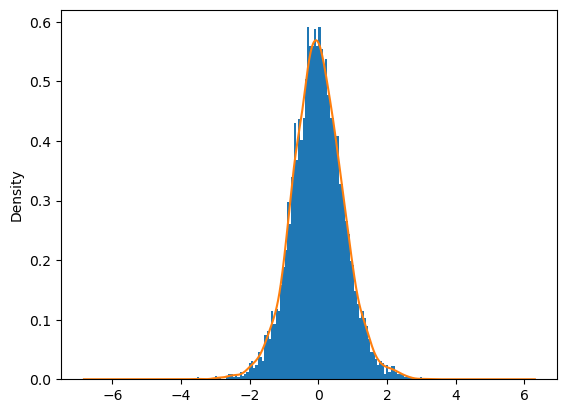

In [11]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

In [12]:
result.to_pickle('ethiopia_estimates.rgsn')

In [13]:
import cfe
result = cfe.regression.read_pickle('ethiopia_estimates.rgsn')

In [14]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

In [15]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)
pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

# Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

    # UNCOMMENT BELOW AND REPLACE STRING WITH FOOD
# use = 'FOOD OF INTEREST'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

NameError: name 'use' is not defined

In [ ]:
fig,ax = plt.subplots()

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f}')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

In [ ]:
fig,ax = plt.subplots()

ax.plot(scale*xref,[result.indirect_utility(s*xref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {xref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')